# Work with spread timeseries
### Denisov Ilia

In [1]:
import numpy as np
import pylab as pl
import pandas as pd
%pylab inline
from datetime import datetime
from collections import Counter
import matplotlib.mlab as mlab
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import pairwise_distances
np.set_printoptions(precision=2, threshold=5)
import scipy as sp
import random
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


## Analysis of timeseries

In [60]:
filepath = 'seeds/ncaa_movement.csv'

In [72]:
df_raw = pd.read_csv(filepath)
df = df_raw.drop(['team_org', 'opponent_team_org'], axis=1)
vals = []
df.head()

,casino,date,time,team,opponent_team,data_datetime,spread_team,spread_opponent
0,pinnacle,20120101,12:00p,RUTG,USF,1/1/2017 12:01,-98.5,-111.5
1,pinnacle,20120101,12:00p,RUTG,USF,1/1/2017 11:44,-101.5,-108.5
2,pinnacle,20120101,12:00p,RUTG,USF,1/1/2017 11:43,-100.5,-109.5
3,pinnacle,20120101,12:00p,RUTG,USF,1/1/2017 11:42,-106.5,96.5
4,pinnacle,20120101,12:00p,RUTG,USF,1/1/2017 11:42,-104.5,-105.5


In [73]:
#add 24-hour formatted time
new_times = []
for i in df.time:
    spl = i.split(':')
    h = spl[0]
    m = spl[1][:-1]
    if i[-1] == 'p' and h!='12':
        
        tmp = 12+int(h)
        hour = '00' if tmp == 24 else tmp
        s = str(hour) + ':' + m
        new_times.append(s)
    else:
        new_times.append(i[:-1])
        
df['time'] = new_times
df.head()

,casino,date,time,team,opponent_team,data_datetime,spread_team,spread_opponent
0,pinnacle,20120101,12:00,RUTG,USF,1/1/2017 12:01,-98.5,-111.5
1,pinnacle,20120101,12:00,RUTG,USF,1/1/2017 11:44,-101.5,-108.5
2,pinnacle,20120101,12:00,RUTG,USF,1/1/2017 11:43,-100.5,-109.5
3,pinnacle,20120101,12:00,RUTG,USF,1/1/2017 11:42,-106.5,96.5
4,pinnacle,20120101,12:00,RUTG,USF,1/1/2017 11:42,-104.5,-105.5


In [75]:
#correct data_datetmie column (invalid year)
new_data_datetime = []
for d, data in zip(df.date, df.data_datetime):
    year = str(d)[:4]
    if str(d)[4:] == '0101' and data[:6] == '12/31/':
        year = str(int(year) - 1)
    pos = data.find('2017')
    if pos == -1:
        pos = data.find('2029')
    new_date = data[:pos] + year + data[pos+4:]
    new_data_datetime.append(new_date)
df['data_datetime'] = new_data_datetime
df.head()


,casino,date,time,team,opponent_team,data_datetime,spread_team,spread_opponent
0,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 12:01,-98.5,-111.5
1,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 11:44,-101.5,-108.5
2,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 11:43,-100.5,-109.5
3,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 11:42,-106.5,96.5
4,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 11:42,-104.5,-105.5


In [76]:
df

,casino,date,time,team,opponent_team,data_datetime,spread_team,spread_opponent
0,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 12:01,-98.5,-111.5
1,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 11:44,-101.5,-108.5
2,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 11:43,-100.5,-109.5
3,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 11:42,-106.5,96.5
4,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 11:42,-104.5,-105.5
5,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 11:10,-99.5,-110.5
6,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 11:10,-98.5,-111.5
7,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 11:10,-110,99
8,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 10:52,-101,-109
9,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 10:52,-103,-107


In [77]:
#correct data_datetime
timestamps = []
for i in df.data_datetime:
    timestamps.append(int(datetime.strptime(i, '%m/%d/%Y %H:%M').timestamp()))
df['data_datetime'] = timestamps
df.head()


,casino,date,time,team,opponent_team,data_datetime,spread_team,spread_opponent
0,pinnacle,20120101,12:00,RUTG,USF,1325404860,-98.5,-111.5
1,pinnacle,20120101,12:00,RUTG,USF,1325403840,-101.5,-108.5
2,pinnacle,20120101,12:00,RUTG,USF,1325403780,-100.5,-109.5
3,pinnacle,20120101,12:00,RUTG,USF,1325403720,-106.5,96.5
4,pinnacle,20120101,12:00,RUTG,USF,1325403720,-104.5,-105.5


In [78]:
#date + time = timestamp
timestamps = []
for d, t in zip(df.date, df.time):
    s = str(d) + ' ' + t
    tmp = int(datetime.strptime(s, '%Y%m%d %H:%M').timestamp())
    timestamps.append(tmp)
df.insert(1, 'game_timestamp', timestamps)
df.head()

,casino,game_timestamp,date,time,team,opponent_team,data_datetime,spread_team,spread_opponent
0,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325404860,-98.5,-111.5
1,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403840,-101.5,-108.5
2,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403780,-100.5,-109.5
3,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403720,-106.5,96.5
4,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403720,-104.5,-105.5


In [79]:
#correct spred (errors like: "PK +115" or "+5 -114")
spread_team = []
for i in df['spread_team']:
    a = float(i.split()[-1])
    spread_team.append(a)
df['spread_team'] = spread_team

spread_opponent = []
for i in df['spread_opponent']:
    if len(i.split()) > 1:
        a = float(i.split()[-1])
    spread_opponent.append(a)
df['spread_opponent'] = spread_opponent

In [80]:
df = df.rename(columns={'data_datetime':'data_timestamp', })
df.head()

,casino,game_timestamp,date,time,team,opponent_team,data_timestamp,spread_team,spread_opponent
0,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325404860,-98.5,-110.0
1,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403840,-101.5,-110.0
2,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403780,-100.5,-110.0
3,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403720,-106.5,-110.0
4,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403720,-104.5,-110.0


In [2]:
df.to_csv('ncaab_spread_movement.csv', index=False)

NameError: name 'df' is not defined

Load correct version of csv file.

In [3]:
filepath = 'ncaab_spread_movement.csv'
df = pd.read_csv(filepath)
df.head()

,casino,game_timestamp,date,time,team,opponent_team,data_timestamp,spread_team,spread_opponent
0,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325404860,-98.5,-110.0
1,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403840,-101.5,-110.0
2,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403780,-100.5,-110.0
3,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403720,-106.5,-110.0
4,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403720,-104.5,-110.0


In [4]:
diff = df.game_timestamp - df.data_timestamp

In [5]:
df.insert(len(df.columns), 'difference', diff)

In [6]:
a = df.groupby(['date', 'team', 'opponent_team', 'casino'])
l = list(a.groups.keys())

Game params: (20160117, 'CAN', 'QUIN', 'bookmaker')
Number of points: 31


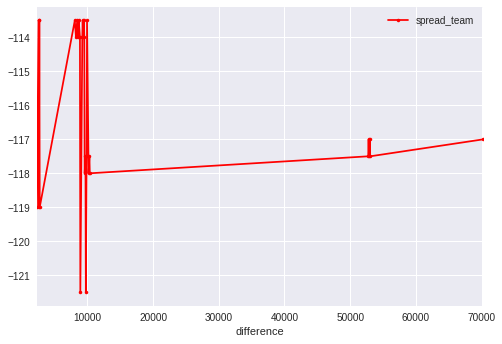

In [71]:
key = random.choice(l)
print('Game params:',key)
tmp = a.get_group(key)
print('Number of points:',len(tmp))
tmp = tmp[tmp.spread_team < 0]
# tmp
tmp.plot.line(x='difference', y='spread_team', marker='.', color='r', linestyle='-', logx=False)